In [ ]:
import shap
#import optuna
import numpy as np
import pandas as pd
import seaborn as sns
#from boruta import BorutaPy
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
#from sklearn.manifold import TSNE
from scipy.spatial import distance
#from lightgbm import LGBMClassifier
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
#from scipy.cluster.hierarchy import fcluster
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [ ]:
def plot_confusion_matrix(y_test,y_pred,title=None,nom=None):
    classes = unique_labels(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(10,10))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    cm_display.plot(ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set(title=title)
    if nom:
        plt.savefig(nom)

def model_xgb(xgb,xtrain,xtest,ytrain,ytest):
    xgb.fit(xtrain, ytrain,eval_set=[(xtrain, ytrain),(xtest,ytest)],verbose=False)
    resultat=xgb.evals_result()
    plt.plot(resultat['validation_0']['logloss'],label='train')
    plt.plot(resultat['validation_1']['logloss'],label='test')
    plt.legend()
    predictions =xgb.predict(xtest)

    # Évaluer les performances du modèle
    accuracy = accuracy_score(ytest, predictions)
    print("accuracy:", accuracy)
    return predictions

In [ ]:
chemin_radiomics='/Users/utilisateur/Desktop/StageCRCT/'
df_final = pd.read_csv(chemin_radiomics+'exemple1.csv')


In [ ]:
colonnes_a_supprimer = [colonne for colonne in df_final.columns if colonne.startswith('original_shape2D') and (colonne.endswith('_red') or colonne.endswith('_green'))]

df_final = df_final.drop(colonnes_a_supprimer,axis=1)

Sain                   622
Leuco keratose         525
Ulcerations            392
Bordure blanche        387
Fissures               244
Erytheme               200
Reticulation           149
Atrophie                79
Erosions                73
Coloration exogene      64
Halo inflammatoire      64
Coloration endogene     37
Vegetation              10
Bulles                   2
Nodules                  1
Name: label, dtype: int64

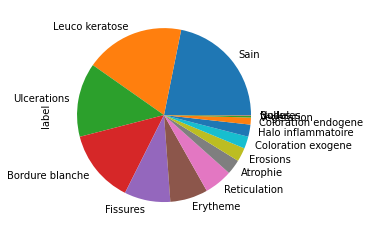

In [ ]:
(df_final['label'].value_counts()).plot.pie()
plt.savefig('no_equi')
df_final['label'].value_counts()


In [ ]:
label_final=df_final['label'].values
y=np.where(label_final=='Sain', 0, 1)

In [ ]:
X=df_final.drop(['name','label','diagnostic'],axis=1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
#import logging
#import warnings
#warnings.filterwarnings("ignore")

#Définir le niveau de journalisation à ERROR pour Optuna
#optuna.logging.set_verbosity(optuna.logging.ERROR)
# Créer votre étude Optuna
#study = optuna.create_study(direction='maximize')


#study.optimize(objective, n_trials=100)
#print('Number of finished trials: {}'.format(len(study.trials)))
#print('Best trial:')
#trial = study.best_trial
#params = trial.params

In [ ]:
params={'max_depth': 9,
 'learning_rate': 0.16713595489732055,
 'n_estimators': 400,
 'min_child_weight': 10,
 'gamma': 0.00016884204745833145,
 'subsample': 0.8318464871349709,
 'colsample_bytree': 0.24302550108239981,
 'reg_alpha': 0.0021236232551450508,
 'reg_lambda': 0.006283295723763449}

accuracy: 0.887719298245614


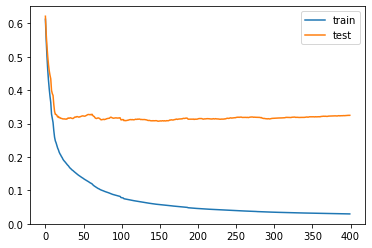

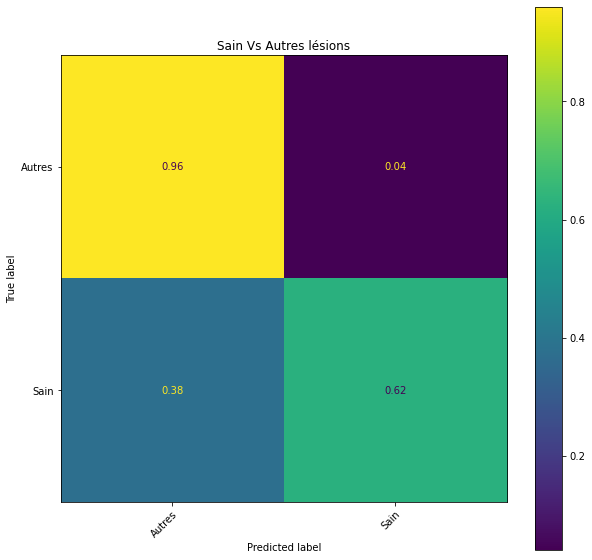

In [ ]:
xgb=XGBClassifier(**params)
predictions=model_xgb(xgb,X_train,X_test,y_train,y_test)


label_orig=np.where(y_test==0,'Sain','Autres')
label_pred=np.where(predictions==0,'Sain','Autres')
plot_confusion_matrix(label_orig, label_pred,nom='binair no équi',title='Sain Vs Autres lésions')

### Boruta

In [ ]:
#feat_selector = BorutaPy(xgb, perc = 100,max_iter = 50  ,verbose = 2,alpha = 0.05)
#X_boruta= X_train.values
#feat_selector.fit(X_boruta, y_train)

In [ ]:
#rankings = np.argsort(feat_selector.ranking_)

# Création d'un DataFrame contenant les noms des variables et leurs classements
#variable_rankings = pd.DataFrame({
 #   'Variable': X_train.columns[rankings],
#   'Classement': feat_selector.ranking_[rankings]
#})

# Sauvegarde du DataFrame au format CSV
#variable_rankings.to_csv('brt_var_br_no_equi.csv', index=False)


In [ ]:
#data=pd.read_csv('brt_var_br_no_equi.csv')
#data

In [ ]:
#confirmed_features = X_train.columns[feat_selector.support_]
#tentative_features = X_train.columns[feat_selector.support_weak_]
#confirmed_features_series = pd.Series(confirmed_features, name='Confirmed Features')
#tentative_features_series = pd.Series(tentative_features, name='Tentative Features')
#all_features = pd.concat([confirmed_features_series, tentative_features_series], ignore_index=True)
#X_train_boruta = X_train.loc[:, all_features]
#X_test_boruta = X_test.loc[:, all_features]

In [ ]:
#xgb=XGBClassifier(**params)
#predictions=model_xgb(xgb,X_train_boruta,X_test_boruta,y_train,y_test)


#label_orig=np.where(y_test==0,'Sain','Autres')
#label_pred=np.where(predictions==0,'Sain','Autres')
#plot_confusion_matrix(label_orig, label_pred,nom='boruta_binair no équi',title='Sain Vs Autres lésions')

In [ ]:
#explainer = shap.Explainer(xgb, X_test)
#shap_values = explainer.shap_values(X_test)

In [ ]:
#shap.summary_plot(shap_values, X_test, show=False)
#plt.savefig('shap_no_equi.png', dpi=300, bbox_inches='tight')

### On va esseyer d'équilibrer les données

In [ ]:
healthy_df = df_final[df_final['label'] == 'Sain']
other_df = df_final[df_final['label'] != 'Sain']
other_df = other_df.sample(frac=1)
sample_size = len(healthy_df)
other_df_sampled = other_df.iloc[:sample_size]
new_df = pd.concat([healthy_df, other_df_sampled])
new_df = new_df.sample(frac=1)


In [ ]:
healthy_df

,name,label,diagnostic,original_shape2D_Elongation_blue,original_shape2D_MajorAxisLength_blue,original_shape2D_MaximumDiameter_blue,original_shape2D_MeshSurface_blue,original_shape2D_MinorAxisLength_blue,original_shape2D_Perimeter_blue,original_shape2D_PerimeterSurfaceRatio_blue,...,original_firstorder_Mean_red,original_firstorder_Median_red,original_firstorder_Minimum_red,original_firstorder_Range_red,original_firstorder_RobustMeanAbsoluteDeviation_red,original_firstorder_RootMeanSquared_red,original_firstorder_Skewness_red,original_firstorder_TotalEnergy_red,original_firstorder_Uniformity_red,original_firstorder_Variance_red
20,CARENCE_X_BASELINE_C.JPG,Sain,Autre anomalie,0.772843,426.289396,421.294434,108477.5,329.454797,1272.028571,0.011726,...,158.320802,160.0,97.0,158.0,13.240733,159.653419,-0.327013,2.765019e+09,0.309693,423.737699
44,GEO_30_BASELINE_C.JPG,Sain,Variation physiologique,0.533748,630.739460,631.547306,166772.5,336.655961,1639.640836,0.009832,...,74.881078,74.0,44.0,186.0,5.201641,75.448722,0.364754,9.493569e+08,0.495698,85.333756
46,GLM_360_BASELINE_A.JPG,Sain,Autre anomalie,0.318669,1053.931725,1025.913252,275589.5,335.855300,2480.383043,0.009000,...,102.750278,100.0,51.0,204.0,8.286174,104.380825,2.321020,3.002651e+09,0.423234,337.737011
47,GLM_360_BASELINE_A.JPG,Sain,Autre anomalie,0.331194,1185.703523,1165.116732,353723.5,392.698386,2799.415439,0.007914,...,104.845382,104.0,51.0,202.0,9.646284,106.863362,1.795078,4.039450e+09,0.390903,427.223987
48,MUCITE_384_BASELINE_A.JPG,Sain,Autre anomalie,0.368903,497.674592,459.047928,68528.5,183.593754,1178.828427,0.017202,...,56.310628,56.0,37.0,187.0,3.265960,56.671664,2.743852,2.200930e+08,0.784993,40.790741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,DBAI_PEMPHIGUS_355_BASELINE_B.JPG,Sain,Autre anomalie,0.464882,635.350966,625.022400,146002.5,295.363295,1596.680374,0.010936,...,84.294638,83.0,51.0,204.0,5.609128,85.584479,4.244770,1.069429e+09,0.578513,219.117082
2838,MUCITE_386_SURVEILLANCE_1A.JPG,Sain,Autre anomalie,0.914372,377.585310,442.417224,97772.5,345.253530,1250.828427,0.012793,...,136.970789,137.0,97.0,158.0,5.618496,137.365787,0.486636,1.844914e+09,0.649270,108.362335
2839,MUCITE_386_SURVEILLANCE_1A.JPG,Sain,Autre anomalie,0.672724,381.049428,397.166212,73259.5,256.340919,1102.828427,0.015054,...,140.686418,141.0,109.0,55.0,4.803538,140.908204,-0.433461,1.454586e+09,0.715191,62.453632
2840,MUCITE_386_SURVEILLANCE_1A.JPG,Sain,Autre anomalie,0.768615,434.165867,473.624324,108663.5,333.706458,1328.828427,0.012229,...,145.108951,145.0,122.0,50.0,4.628403,145.308502,0.156152,2.294393e+09,0.585188,57.953187


Sain                   622
Leuco keratose         525
Ulcerations            392
Bordure blanche        387
Fissures               244
Erytheme               200
Reticulation           149
Atrophie                79
Erosions                73
Coloration exogene      64
Halo inflammatoire      64
Coloration endogene     37
Vegetation              10
Bulles                   2
Nodules                  1
Name: label, dtype: int64

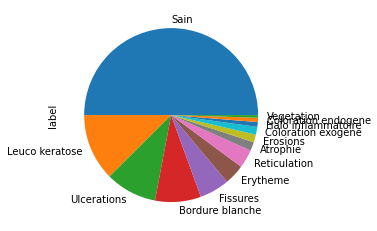

In [ ]:
(new_df['label'].value_counts()).plot.pie()
plt.savefig('equi')
df_final['label'].value_counts()

In [ ]:
label1=new_df['label'].values
y1=np.where(label1=='Sain', 0, 1)
X1=new_df.drop(['name','label','diagnostic'],axis=1)
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,test_size=0.2,random_state=42)

accuracy: 0.8393574297188755


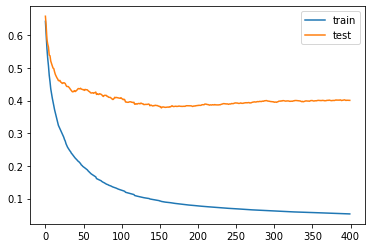

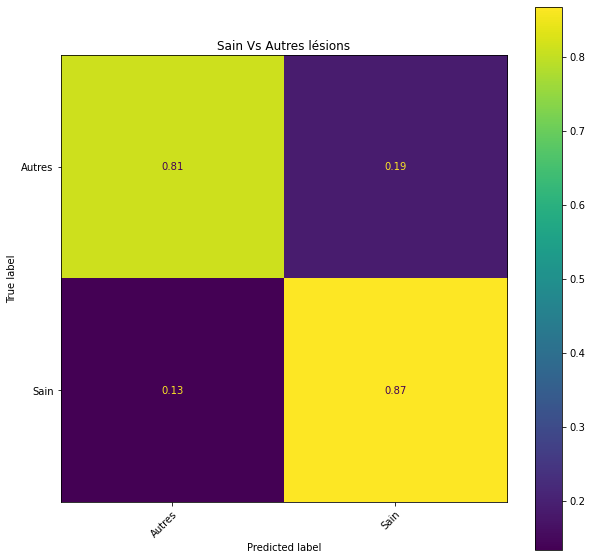

In [ ]:
xgb=XGBClassifier(**params)
predictions1=model_xgb(xgb,X_train1,X_test1,y_train1,y_test1)
label_orig1=np.where(y_test1==0,'Sain','Autres')
label_pred1=np.where(predictions1==0,'Sain','Autres')
plot_confusion_matrix(label_orig1, label_pred1,title='Sain Vs Autres lésions')

In [ ]:
#proba_predictions = xgb.predict_proba(X_test1)
#proba_sain = proba_predictions[:, 0]
#proba_lesion = proba_predictions[:, 1]
#proba_sain

In [ ]:
#confirmed_features = X_train1.columns[feat_selector.support_]
#tentative_features = X_train1.columns[feat_selector.support_weak_]
#confirmed_features_series = pd.Series(confirmed_features, name='Confirmed Features')
#tentative_features_series = pd.Series(tentative_features, name='Tentative Features')
#all_features = pd.concat([confirmed_features_series, tentative_features_series], ignore_index=True)
#X_train_boruta1 = X_train1.loc[:, all_features]
#X_test_boruta1 = X_test1.loc[:, all_features]

In [ ]:
explainer = shap.Explainer(xgb, X_train1)
shap_values = explainer.shap_values(X_train1)

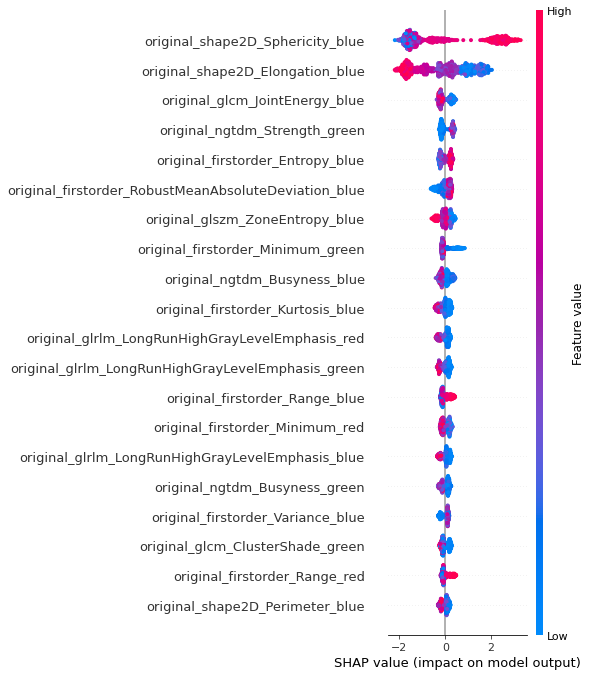

In [ ]:
shap.summary_plot(shap_values, X_train1,show=False)
#plt.savefig('shap_equi', dpi=300, bbox_inches='tight')

In [ ]:
#shap_values = explainer.shap_values(X_test_boruta1)
#mean_shap_values = shap_values.mean(axis=0)
#positive_impact_vars = X_test_boruta1.columns[mean_shap_values > 0]
#negative_impact_vars = X_test_boruta1.columns[mean_shap_values < 0]

# Afficher les variables avec impact positif et négatif
#print("Variables avec impact positif :", positive_impact_vars)
#print("Variables avec impact négatif :", negative_impact_vars)
# Créer un diagramme en barres pour visualiser les moyennes des valeurs SHAP
#plt.figure(figsize=(10, 6))
#plt.barh(positive_impact_vars, mean_shap_values[mean_shap_values > 0], color='red', label='Positive Impact')
#plt.barh(negative_impact_vars, mean_shap_values[mean_shap_values < 0], color='blue', label='Negative Impact')
#plt.xlabel('Mean SHAP Value')
#plt.title('Impact des variables sur les prédictions du modèle')
#plt.legend()
#plt.show()

### les distributions sur les caractéristiques discriminantes

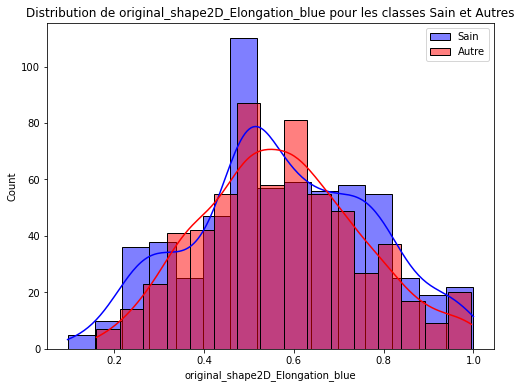

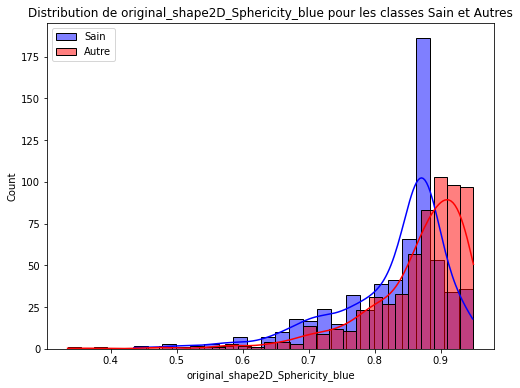

In [ ]:
features=['original_shape2D_Elongation_blue','original_shape2D_Sphericity_blue']
# Boucle sur chaque caractéristique et trace des graphiques pour les distributions
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(healthy_df[feature], color='blue', kde=True, label='Sain', alpha=0.5)
    sns.histplot(other_df_sampled[feature], color='red', kde=True, label='Autre', alpha=0.5)
    plt.title(f'Distribution de {feature} pour les classes Sain et Autres')
    plt.xlabel(feature)
    plt.legend()
    plt.savefig(feature)
    plt.show()


## Test avec les variable shape2D

In [ ]:
# Pour l'image 'VIROSE_472_BASELINE_B.JPG'
test=pd.read_csv("test.csv")
test = test[X_test1.columns]
test

In [ ]:
pred = xgb.predict(test)
prob = xgb.predict_proba(test)

In [ ]:
pred

In [ ]:
prob

In [ ]:
explainer = shap.Explainer(xgb, test)
shap_values = explainer.shap_values(test)

In [ ]:
shap.summary_plot(shap_values,test,show=False)

In [ ]:
# Pour l'image 'ULCERATION_X_BASELINE_N.JPG'
test1=pd.read_csv("test1.csv")
test1 = test1[X_test1.columns]
test1

In [ ]:
pred = xgb.predict(test1)
prob = xgb.predict_proba(test1)

In [ ]:
pred

In [ ]:
prob